In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('23_DS_Project_수정/train.csv')

In [3]:
data['period'] = pd.to_datetime(data['buydate']).sub(pd.to_datetime(data['date']))
data['period'] = data['period'].apply(lambda x: x.days)

In [4]:
torch.log(torch.tensor((data['period'] + 1).values,dtype=torch.float32))

tensor([4.5326, 3.9512, 4.0775,  ..., 4.4886, 2.4849, 3.4012])

In [5]:
data['month'] = pd.to_datetime(data['date']).dt.month

In [6]:
monthes = pd.get_dummies(data['month'])
monthes

,4,5,6
0,False,False,True
1,False,True,False
2,False,True,False
3,False,True,False
4,True,False,False
...,...,...,...
9995,False,False,True
9996,False,True,False
9997,False,False,True
9998,True,False,False


In [7]:
data = pd.concat([data, monthes], axis=1)
data

,index,Num,prod,insp,date,buydate,ingr_A,ingr_B,ingr_C,wtcd,gram,label,period,month,4,5,6
0,2,20230618산천074246A,GBMD,C,2023-06-18,2023-09-18,399.4063,6.4035,6.9409,F3,970.32,1,92,6,False,False,True
1,9,20230518창하053396B,GGMD,L,2023-05-18,2023-07-08,130.0951,5.8245,6.2857,F1,2490.08,0,51,5,False,True,False
2,10,20230505창하063135B,KCMD,C,2023-05-05,2023-07-02,131.5192,5.8040,6.0607,F3,487.37,0,58,5,False,True,False
3,12,20230505산천001612A,GBMD,K,2023-05-05,2023-06-04,128.5978,6.8720,6.1705,F3,707.94,1,30,5,False,True,False
4,16,20230409수성016088C,JJBB,K,2023-04-09,2023-04-14,320.6915,5.7474,6.3695,F3,1978.66,0,5,4,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,49974,20230620산천071749A,KCMD,C,2023-06-20,2023-07-08,405.6626,6.2900,6.8467,F3,777.82,0,18,6,False,False,True
9996,49980,20230515오포006371A,GGMD,K,2023-05-15,2023-05-25,129.1664,6.0345,6.5257,F3,2548.73,0,10,5,False,True,False
9997,49981,20230614창하058590B,GGMD,L,2023-06-14,2023-09-10,403.9895,6.2698,6.7227,F1,2769.71,0,88,6,False,False,True
9998,49985,20230405산천007488A,JJBB,K,2023-04-05,2023-04-16,309.4751,5.7987,6.5499,F3,2005.46,0,11,4,True,False,False


In [8]:
data['A'] = data['ingr_A'] / data['gram']
data['B'] = data['ingr_B'] / data['gram']
data['C'] = data['ingr_C'] / data['gram']

In [26]:
def normalize(x, mean, std):
    return (x - mean) / std

def splitProd(x):
    values = {
        'GBMD': (879.3651756832124,117.84607328270515), 
        'GGMD': (2634.8855460750856, 119.30075376693733), 
        'KCMD': (661.5973034117862, 113.40886581106393),
        'JJBB': (1956.4619719626169, 114.33567278455949),
        }
    mean, std = values[x['prod']]
    return normalize(x['gram'],mean,std)

data['normalized_gram'] = data.apply(splitProd,axis=1)


In [111]:
def splitIngr(x):
    values = {
        4: (321.22854500150106,5.398541848242033), 
        5: (128.53502740147783, 14.247184944625705), 
        6: (397.7575242176075, 4.344446713182801),
        }
    mean, std = values[x['month']]
    return normalize(x['ingr_A'],mean,std)

data['normalized_A'] = data.apply(splitProd,axis=1)

/var/folders/c6/ctffry256psfvzxk56lgsqdh0000gn/T/ipykernel_854/1220887614.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['normalized_A'] = data.apply(splitProd,axis=1)


In [131]:
features = ['normalized_A','normalized_gram','period']
#features = ['A','B','C','gram',4,5,6]
X = data[features]
y = data['label']

In [132]:
floatData = torch.FloatTensor(data[['normalized_A','normalized_gram']].values)
#booleanData = torch.BoolTensor(data[[4,5,6]].values)
intData = torch.log(torch.FloatTensor((data['period']+1).values))

X = torch.cat((floatData,intData.unsqueeze(1)), dim=1)

In [74]:
def wtcdData(wtcd):
    # wtcd 별로 데이터를 나누어서 학습
    f_data = data[data['wtcd']==wtcd]
    y = f_data['label']

    floatData = torch.FloatTensor(f_data[['A','B','C','normalized_gram']].values)
    booleanData = torch.BoolTensor(f_data[[4,5,6]].values)
    intData = torch.log(torch.FloatTensor((f_data['period']+1).values))

    X = torch.cat((floatData,booleanData,intData.unsqueeze(1)), dim=1)
    
    return X, y

In [81]:
X, y = wtcdData('F3')

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [134]:
X_train

tensor([[ 0.4612,  0.4612,  4.8520],
        [ 0.5805,  0.5805,  1.0986],
        [-1.4098, -1.4098,  0.6931],
        ...,
        [ 0.3844,  0.3844,  3.6636],
        [ 0.8403,  0.8403,  1.7918],
        [ 0.9823,  0.9823,  2.8904]])

In [135]:
class FC(nn.Module):
    def __init__(self, num_features):
        super(FC, self).__init__()
        # 첫 번째 은닉층
        # ingr_A, ingr_B, ingr_C, gram
        self.fc1 = nn.Linear(num_features, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)
        self.relu1 = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu1(out)
        out = self.fc3(out)
        out = self.relu1(out)
        out = self.fc4(out)
        out = self.sigmoid(out)
        return out

In [85]:
class AutoEncoder(nn.Module):
    def __init__(self, num_features):
        super(Encoder, self).__init__()
        # 첫 번째 은닉층
        # ingr_A, ingr_B, ingr_C, gram
        self.Encoder = nn.Sequential(
            nn.Linear(num_features,32),
            nn.ReLU(),
            nn.Linear(32,64),
            nn.ReLU()
        )
        self.Decoder = nn.Sequential(
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,num_features)
        )

    def forward(self, x, mode='full'):
        out = self.Encoder(x)
        
        if mode == 'full':
            out = self.Decoder(out)
        
        return out

In [136]:
model  = FC(len(features))
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(),lr=0.01)

In [137]:
num_epochs = 50
batch_size = 100

for epoch in range(num_epochs):
    with tqdm(total=len(X_train)//batch_size, unit="epoch", desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for batch in range(0,len(X_train),batch_size):
            optimizer.zero_grad()
            batch_data = X_train[batch:batch+batch_size]
            batch_label = torch.tensor(y_train[batch:batch+batch_size].values,dtype=torch.float32).unsqueeze(0).permute(1,0)
            pred = model(batch_data)
            loss = criterion(pred,batch_label)
            
            # 손실 값을 tqdm에 업데이트
            pbar.set_postfix(loss=loss.item())
            pbar.update(1)
            
            loss.backward()
            optimizer.step()

Epoch 1/50: 80epoch [00:02, 36.50epoch/s, loss=0.566]                     
Epoch 2/50: 80epoch [00:01, 52.94epoch/s, loss=0.571]                     
Epoch 3/50: 80epoch [00:01, 49.34epoch/s, loss=0.573]                     
Epoch 4/50: 80epoch [00:01, 52.46epoch/s, loss=0.571]                     
Epoch 5/50: 80epoch [00:01, 51.61epoch/s, loss=0.577]                     
Epoch 6/50: 80epoch [00:01, 46.45epoch/s, loss=0.577]                     
Epoch 7/50: 80epoch [00:01, 50.04epoch/s, loss=0.576]                     
Epoch 8/50: 80epoch [00:01, 50.52epoch/s, loss=0.579]                     
Epoch 9/50: 80epoch [00:01, 44.28epoch/s, loss=0.58]                      
Epoch 10/50: 80epoch [00:01, 41.43epoch/s, loss=0.578]                     
Epoch 11/50: 80epoch [00:01, 41.10epoch/s, loss=0.582]                     
Epoch 12/50: 80epoch [00:01, 43.75epoch/s, loss=0.592]                     
Epoch 13/50: 80epoch [00:01, 44.19epoch/s, loss=0.582]                     
Epoch 14/50: 80epoch 

KeyboardInterrupt: 

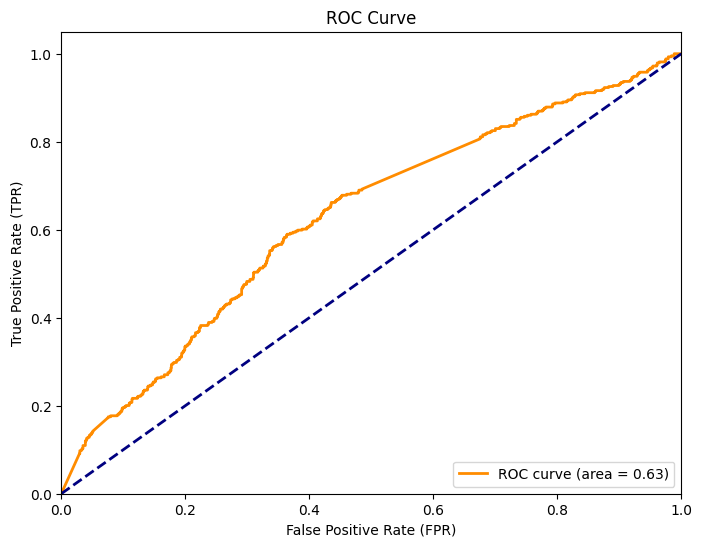

ROC AUC Score: 0.6258207101618941


In [120]:
with torch.no_grad():
    #torch_data = torch.tensor(X_test.values,dtype=torch.float32)
    y_pred_prob = model(X_test).squeeze().numpy()

# 실제 레이블과 예측 확률을 사용하여 ROC 곡선을 계산합니다.
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# ROC 곡선을 그립니다.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# ROC AUC (Area Under the Curve)를 계산합니다.
roc_auc = roc_auc_score(y_test, y_pred_prob)
print('ROC AUC Score:', roc_auc)

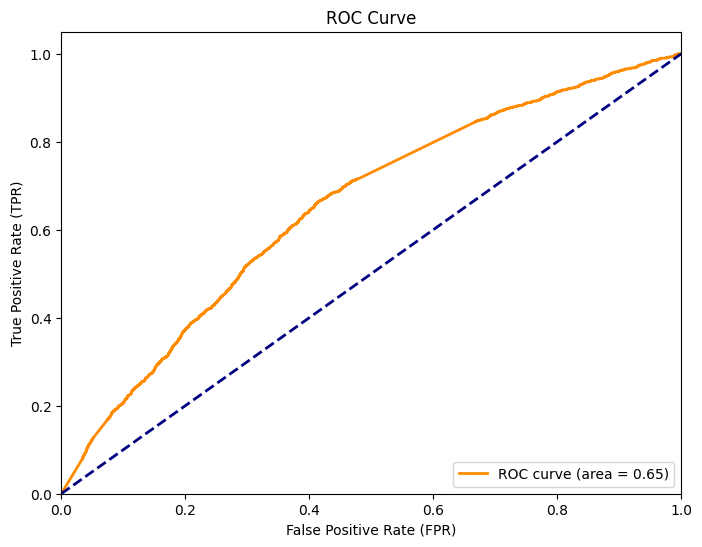

ROC AUC Score: 0.6510481081159741


In [121]:
with torch.no_grad():
    #torch_data = torch.tensor(X_test.values,dtype=torch.float32)
    y_pred_prob = model(X_train).squeeze().numpy()

# 실제 레이블과 예측 확률을 사용하여 ROC 곡선을 계산합니다.
fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob)

# ROC 곡선을 그립니다.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# ROC AUC (Area Under the Curve)를 계산합니다.
roc_auc = roc_auc_score(y_train, y_pred_prob)
print('ROC AUC Score:', roc_auc)